In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv
/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv


https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate/data  
multi variable single time step pred  
based on https://www.kaggle.com/code/farshadjafari97/lstm-forcasting-with-pytorch

## Load libraries

In [2]:
## Load libraries

In [3]:
import numpy as np
import pandas as pd

from time import strptime, strftime

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

import torch
from torch import nn
from torch.nn import LSTM

from torch.utils.data import TensorDataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load data

In [4]:
df_train = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv")
df_test = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv")
date = df_train['date'].apply(lambda x: strptime(x, '%Y-%m-%d %H:%M:%S'))
print(date)
df_train = df_train.drop(columns=['date'])
print('train_data'.center(64, '-'))
print(df_train.shape)
print(df_train.head())
print('test_data'.center(64, '-'))
print(df_test.shape)
print(df_test.head())

0             (2010, 1, 2, 0, 0, 0, 5, 2, -1)
1             (2010, 1, 2, 1, 0, 0, 5, 2, -1)
2             (2010, 1, 2, 2, 0, 0, 5, 2, -1)
3             (2010, 1, 2, 3, 0, 0, 5, 2, -1)
4             (2010, 1, 2, 4, 0, 0, 5, 2, -1)
                         ...                 
43795    (2014, 12, 31, 19, 0, 0, 2, 365, -1)
43796    (2014, 12, 31, 20, 0, 0, 2, 365, -1)
43797    (2014, 12, 31, 21, 0, 0, 2, 365, -1)
43798    (2014, 12, 31, 22, 0, 0, 2, 365, -1)
43799    (2014, 12, 31, 23, 0, 0, 2, 365, -1)
Name: date, Length: 43800, dtype: object
---------------------------train_data---------------------------
(43800, 8)
   pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
0      129.0  -16  -4.0  1020.0      SE     1.79     0     0
1      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2      159.0  -11  -5.0  1021.0      SE     3.57     0     0
3      181.0   -7  -5.0  1022.0      SE     5.36     1     0
4      138.0   -7  -5.0  1022.0      SE     6.25     2     0
-----------

### check null values

In [5]:
print('train_data'.center(64, '-'))
print(df_train.isnull().sum())
print('test_data'.center(64, '-'))
print(df_test.isnull().sum())

---------------------------train_data---------------------------
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
---------------------------test_data----------------------------
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
pollution    0
dtype: int64


### show basic information

In [6]:
print('train_data'.center(64, '-'))
print('columns of train_data'.center(50, '-'))
print(df_train.columns)
for i, c in enumerate(df_train.columns):
    print(c.center(32, '-'))
    print(df_train[c].value_counts())
    print(df_train[c].describe())

---------------------------train_data---------------------------
--------------columns of train_data---------------
Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain'],
      dtype='object')
-----------pollution------------
pollution
0.0      2045
16.0      626
11.0      596
13.0      589
12.0      578
         ... 
558.0       1
980.0       1
491.0       1
524.0       1
580.0       1
Name: count, Length: 581, dtype: int64
count    43800.000000
mean        94.013516
std         92.252276
min          0.000000
25%         24.000000
50%         68.000000
75%        132.250000
max        994.000000
Name: pollution, dtype: float64
--------------dew---------------
dew
 18    1323
 17    1294
 19    1290
 16    1238
 20    1219
       ... 
-36       3
-37       3
-38       2
-39       1
-40       1
Name: count, Length: 69, dtype: int64
count    43800.000000
mean         1.828516
std         14.429326
min        -40.000000
25%        -10.000000
50%        

### draw time series plots  
time_stamp : <class 'time.struct_time'>

([0, 720, 1392, 2136, 2856, 3600, 4320, 5064, 5808, 6528, 7272, 7992, 8736, 9480, 10152, 10896, 11616, 12360, 13080, 13824, 14568, 15288, 16032, 16752, 17496, 18240, 18936, 19680, 20400, 21144, 21864, 22608, 23352, 24072, 24816, 25536, 26280, 27024, 27696, 28440, 29160, 29904, 30624, 31368, 32112, 32832, 33576, 34296, 35040, 35784, 36456, 37200, 37920, 38664, 39384, 40128, 40872, 41592, 42336, 43056, 43799], ['10-1-2 0:00', '10-2-1 0:00', '10-3-1 0:00', '10-4-1 0:00', '10-5-1 0:00', '10-6-1 0:00', '10-7-1 0:00', '10-8-1 0:00', '10-9-1 0:00', '10-10-1 0:00', '10-11-1 0:00', '10-12-1 0:00', '11-1-1 0:00', '11-2-1 0:00', '11-3-1 0:00', '11-4-1 0:00', '11-5-1 0:00', '11-6-1 0:00', '11-7-1 0:00', '11-8-1 0:00', '11-9-1 0:00', '11-10-1 0:00', '11-11-1 0:00', '11-12-1 0:00', '12-1-1 0:00', '12-2-1 0:00', '12-3-1 0:00', '12-4-1 0:00', '12-5-1 0:00', '12-6-1 0:00', '12-7-1 0:00', '12-8-1 0:00', '12-9-1 0:00', '12-10-1 0:00', '12-11-1 0:00', '12-12-1 0:00', '13-1-1 0:00', '13-2-1 0:00', '13-3-1 

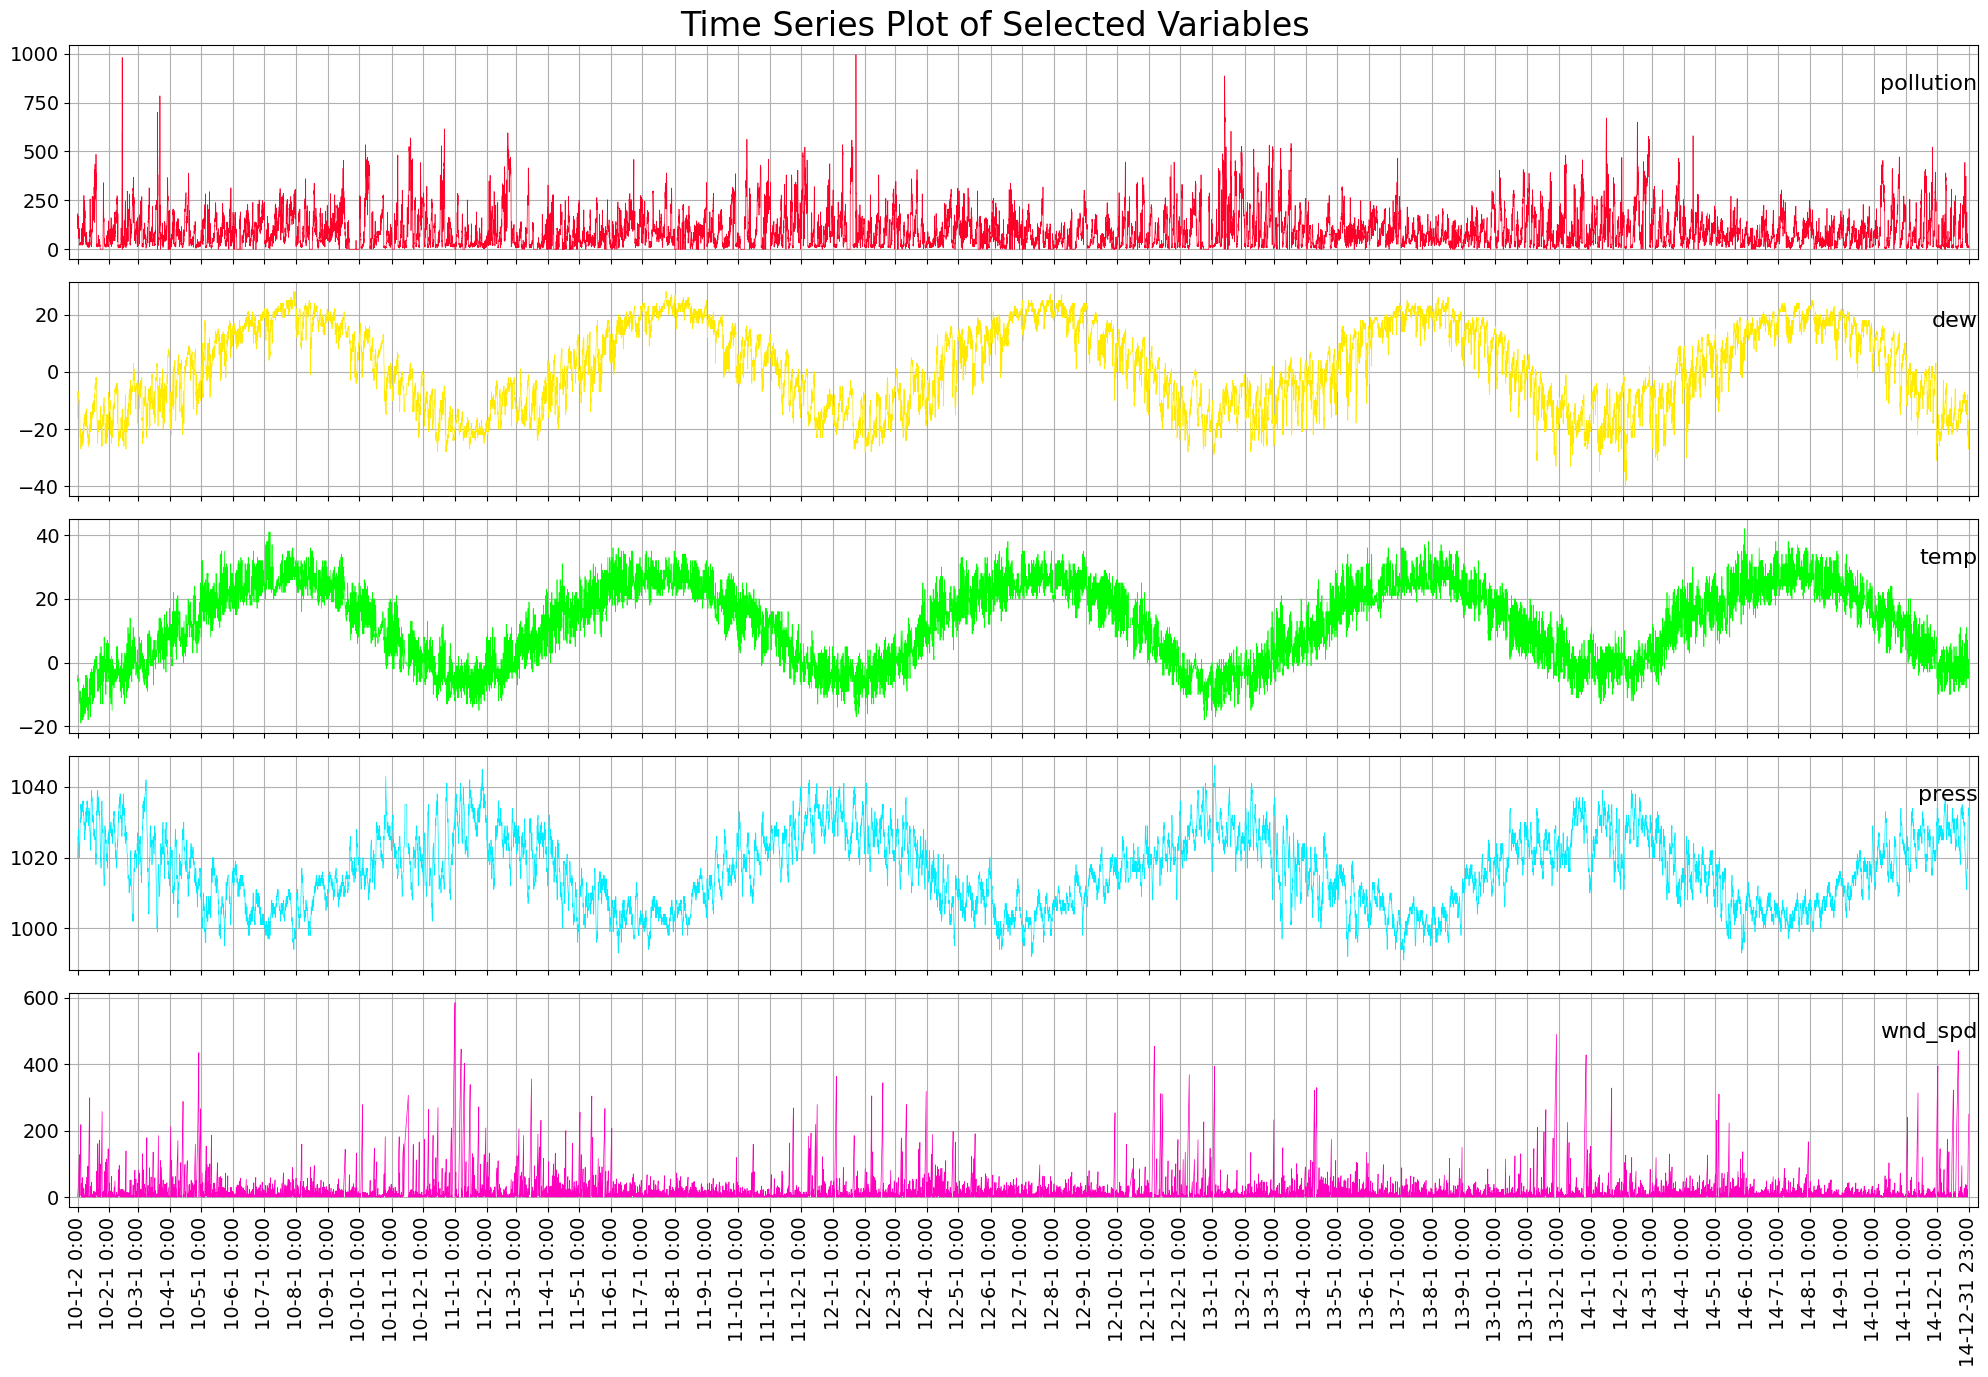

In [7]:
def get_ticks(date):
    idx = list()
    date_stamp = list()
    if not (date[0].tm_mday==1 and date[0].tm_hour==0):
        idx.append(0)
        date_stamp.append(f'{date[0].tm_year%100}-{date[0].tm_mon}-{date[0].tm_mday} {date[0].tm_hour}:00')
    i = 0
    for i, d in enumerate(date):
        if d.tm_mday==1 and d.tm_hour==0:
            idx.append(i)
            date_stamp.append(f'{d.tm_year%100}-{d.tm_mon}-{d.tm_mday} {d.tm_hour}:00')
    if not (date[i].tm_mday==1 and date[i].tm_hour==0):
        idx.append(i)
        date_stamp.append(f'{date[i].tm_year%100}-{date[i].tm_mon}-{date[i].tm_mday} {date[i].tm_hour}:00')
    return idx, date_stamp

print(get_ticks(date))

values = df_train.values

groups = [0, 1, 2, 3, 5]
i = 1

# plot each column
fig, axs = plt.subplots(len(groups), 1, figsize=(20, 14), facecolor='white', sharex=True)
for group, ax in zip(groups, axs):
    ax.plot(values[:, group], linewidth=0.5, color=cm.gist_rainbow(group/len(groups)))
    ax.set_xlim(-200, 44000)
    ax.set_title(df_train.columns[group], y=0.75, loc='right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    #ax.set_xticks([43799], ['2014-12-31 23:00'], rotation=90)
    ax.set_xticks(*get_ticks(date), rotation=90)
    #ax.set_xticks(np.arange(0, df_train.shape[0], 720), date[np.arange(0, df_train.shape[0], 720)], rotation=90)
    ax.grid(True)
    i += 1

plt.suptitle('Time Series Plot of Selected Variables', fontsize=24)
plt.tight_layout()
plt.show()

### preprocess data  
MinMaxScaler

In [8]:
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
df_test_scaled = df_test_scaled[df_train.columns]

mapping = {
    'SE': 0,
    'NW': 1,
    'NE': 2,
    'cv': 3,
}

df_train_scaled['wnd_dir'] = df_train_scaled['wnd_dir'].map(mapping)
df_test_scaled['wnd_dir'] = df_test_scaled['wnd_dir'].map(mapping)

scaler = MinMaxScaler()
columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
scaler.fit(df_train_scaled[columns])

df_train_scaled[columns] = scaler.transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

print('train_data'.center(64, '-'))
print(df_train_scaled.head())
print('test_data'.center(64, '-'))
print(df_test_scaled.head())

---------------------------train_data---------------------------
   pollution       dew      temp     press  wnd_dir   wnd_spd      snow  rain
0   0.129779  0.352941  0.245902  0.527273      0.0  0.002290  0.000000   0.0
1   0.148893  0.367647  0.245902  0.527273      0.0  0.003811  0.000000   0.0
2   0.159960  0.426471  0.229508  0.545455      0.0  0.005332  0.000000   0.0
3   0.182093  0.485294  0.229508  0.563636      0.0  0.008391  0.037037   0.0
4   0.138833  0.485294  0.229508  0.563636      0.0  0.009912  0.074074   0.0
---------------------------test_data----------------------------
   pollution       dew      temp     press   wnd_dir   wnd_spd  snow  rain
0   0.128773  0.352941  0.377049  0.654545  0.000000  0.005349   0.0   0.0
1   0.077465  0.338235  0.393443  0.654545  0.000000  0.012219   0.0   0.0
2   0.065392  0.352941  0.377049  0.654545  0.000000  0.015278   0.0   0.0
3   0.079477  0.352941  0.327869  0.672727  1.000000  0.000752   0.0   0.0
4   0.093561  0.382353  0.3

## Define train data

In [9]:
window_size = 10

# TrainSet
X_sequences = []
y_values = []

for i in range(len(df_train_scaled)-window_size):
    X_seq = df_train_scaled.iloc[i:i+window_size].values
    y_val = df_train_scaled.iloc[i+window_size].pollution.item()
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_train = np.array(X_sequences)
y_train = np.array(y_values)

# TestSet
X_sequences = []
y_values = []
for i in range(len(df_test_scaled) - window_size):
    X_seq = df_test_scaled.iloc[i:i+window_size].values
    Y_val = df_test_scaled.iloc[i+window_size]['pollution']
    X_sequences.append(X_seq)
    y_values.append(Y_val)

X_test = np.array(X_sequences)
y_test = np.array(y_values)

print('train_data'.center(50, '-'))
print(X_train.shape)
print(y_train.shape)
print('test_data'.center(50, '-'))
print(X_test.shape)
print(y_test.shape)

--------------------train_data--------------------
(43790, 10, 8)
(43790,)
--------------------test_data---------------------
(336, 10, 8)
(336,)


In [10]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1,1))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1,1))

## Define model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
class SeqModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, device):
        super(SeqModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        # final output is transformed from hidden state, like traditional RNNs
        self.fc = nn.Linear(hidden_size, output_size)
        self.device = device
        return
    
    def forward(self, x):
        # initialize hidden states for each (LSTM)layer and batch
        # all zeros (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        # LSTM
        out, _ = self.lstm(x, (h0, c0))
        # print(out.shape)
        # second dim : sequence length
        out = self.fc(out[:, -1, :])
        return out

In [13]:
num_layers = 1
hidden_size = 32
input_size = 8
output_size = 1

model = SeqModel(input_size, hidden_size, num_layers, output_size, device)\
    .to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
scheduler  = torch.optim.lr_scheduler.StepLR(
    optimizer, 5, 0.5, last_epoch=-1, verbose=False,
)
criterion = nn.MSELoss()

print(model)

SeqModel(
  (lstm): LSTM(8, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## Load data

In [14]:
batch_size = 128

train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )

test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )

## Train model

In [15]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [16]:
num_epochs = 25

train_losses = []  # To store train losses
test_losses = []   # To store test losses

for epoch in range(num_epochs):
    model.train()
    train_loss = []
    i = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.reshape(-1, 10, 8).to(device)
        targets = targets.reshape(-1, 1).to(device)
        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
    print(scheduler.get_last_lr())
    print(f'Epoch: {epoch}, train_avg_loss: {sum(train_loss)/len(train_loss)}')
    scheduler.step()
    model.eval()
    test_loss = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.reshape(-1, 10, 8).to(device)
            targets = targets.reshape(-1, 1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        print(f'Epoch: {epoch}, test_avg_loss: {sum(test_loss)/len(test_loss)}')
    pass

[0.05]
Epoch: 0, train_avg_loss: 0.00905994195300454
Epoch: 0, test_avg_loss: 0.008956676349043846
[0.05]
Epoch: 1, train_avg_loss: 0.008362009402429848
Epoch: 1, test_avg_loss: 0.007260748650878668
[0.05]
Epoch: 2, train_avg_loss: 0.007813835728978901
Epoch: 2, test_avg_loss: 0.007605823688209057
[0.05]
Epoch: 3, train_avg_loss: 0.007247651955766375
Epoch: 3, test_avg_loss: 0.006628474686294794
[0.05]
Epoch: 4, train_avg_loss: 0.0066208929117572935
Epoch: 4, test_avg_loss: 0.006729199318215251
[0.025]
Epoch: 5, train_avg_loss: 0.006101763251030611
Epoch: 5, test_avg_loss: 0.005171285942196846
[0.025]
Epoch: 6, train_avg_loss: 0.005724564948996083
Epoch: 6, test_avg_loss: 0.005476087331771851
[0.025]
Epoch: 7, train_avg_loss: 0.005324502350974893
Epoch: 7, test_avg_loss: 0.004680455895140767
[0.025]
Epoch: 8, train_avg_loss: 0.004902468777768183
Epoch: 8, test_avg_loss: 0.0039598396979272366
[0.025]
Epoch: 9, train_avg_loss: 0.0044664607195412384
Epoch: 9, test_avg_loss: 0.004110004054

## test on test set

torch.Size([336, 1])
torch.Size([336, 1])


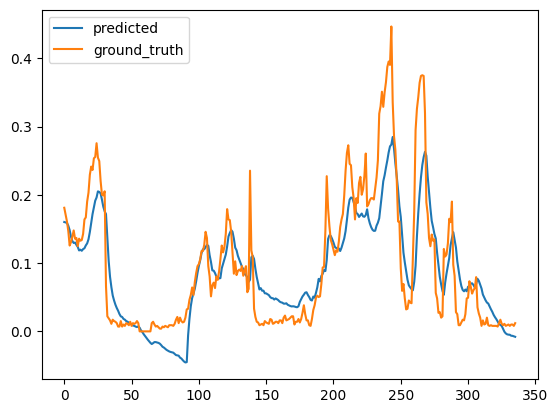

In [17]:
with torch.no_grad():
    predicted = model(X_test.reshape(-1, 10, 8).to(device))
predicted = predicted.to('cpu')
print(predicted.shape)

print(y_test.shape)

fig, ax = plt.subplots(1, 1)
ax.plot(predicted.detach().numpy(), label='predicted')
ax.plot(y_test, label='ground_truth')
ax.legend()
plt.show()